# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

Our dataset, "bank-additional-full.csv", has 41188 rows and 20 campaigns, ordered by date, from May 2008 to November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
import graphviz

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



**Look For Missing Values**

In [4]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


From this we can see that we have no missing values in the dataset.

**Look For Duplicate Values**

In [5]:
print("There are", df.duplicated().sum(),"duplicate values in the dataset.")

There are 12 duplicate values in the dataset.


Lets drop all of the duplicates

In [6]:
df = df.drop_duplicates()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

### EDA

In [8]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for var in cat_cols:
    print(df[var].value_counts(), '\nlenght:', len(df[var].unique()), '\n\n')

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64 
lenght: 12 


marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64 
lenght: 4 


education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64 
lenght: 8 


default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64 
lenght: 3 


housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64 
lenght: 3 


loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int

Theres a large disparity between the yes and no values for our Y variable.

In [9]:
df['y'].value_counts(normalize=True)

,proportion
y,
no,0.887337
yes,0.112663


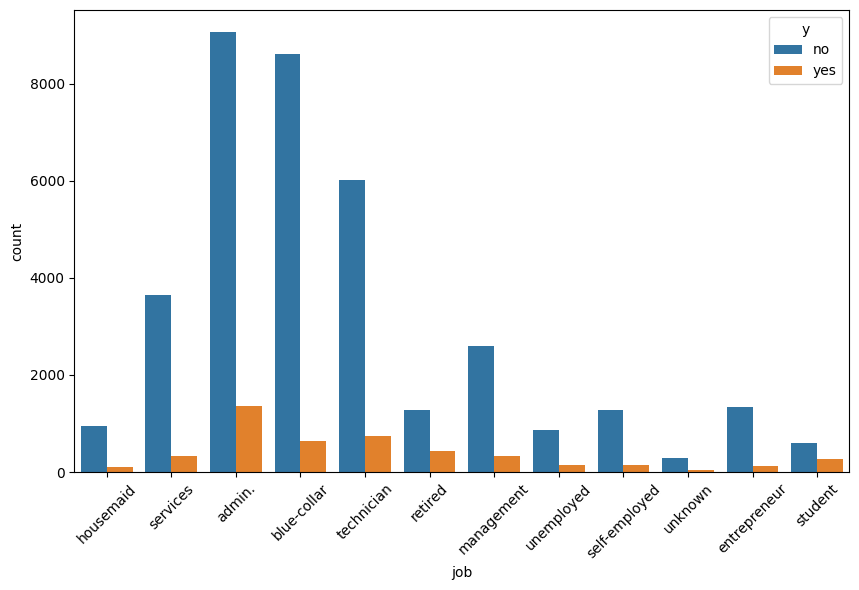

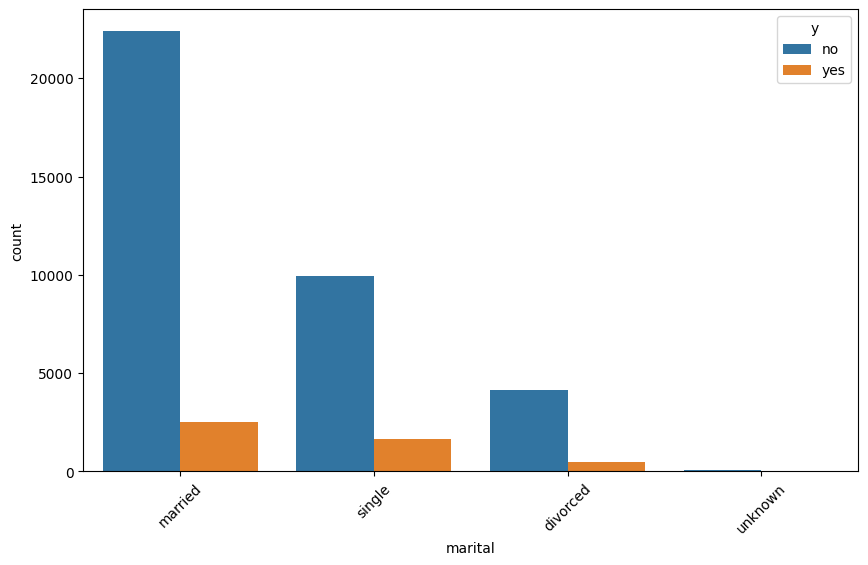

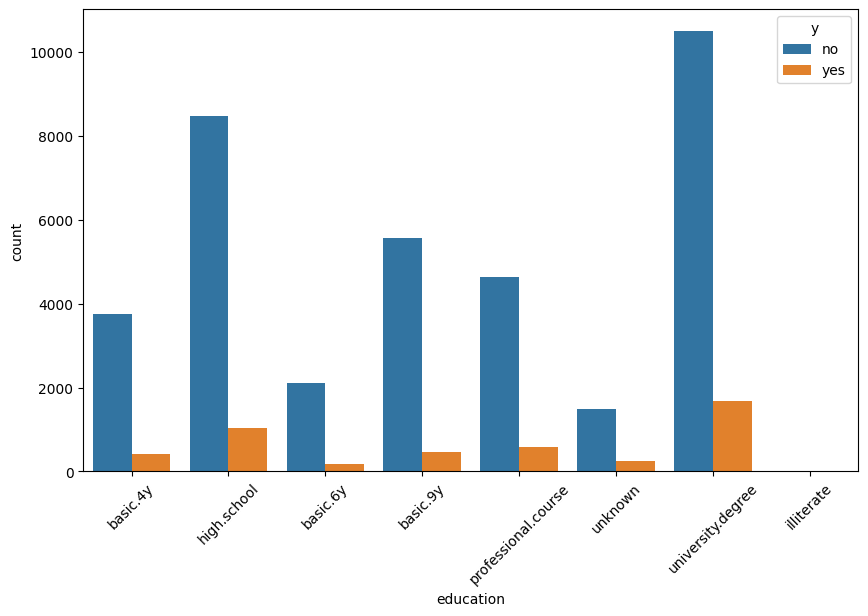

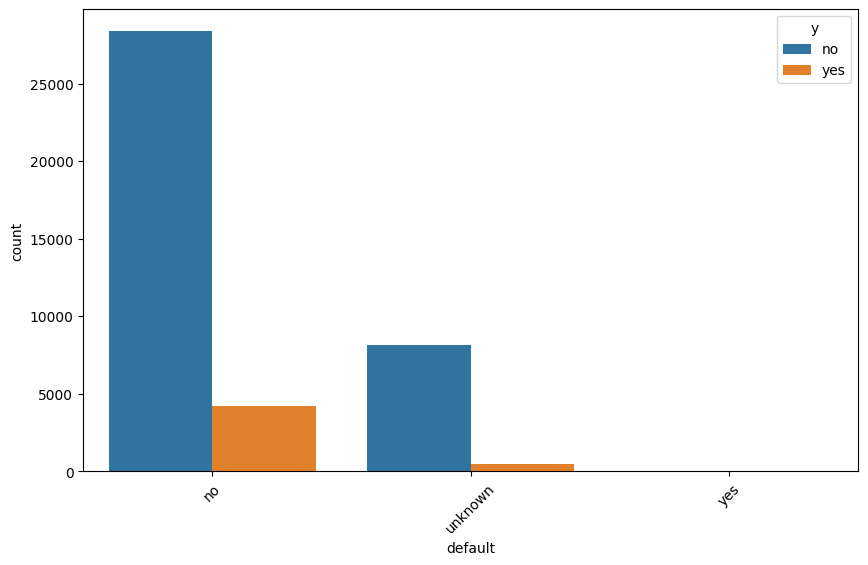

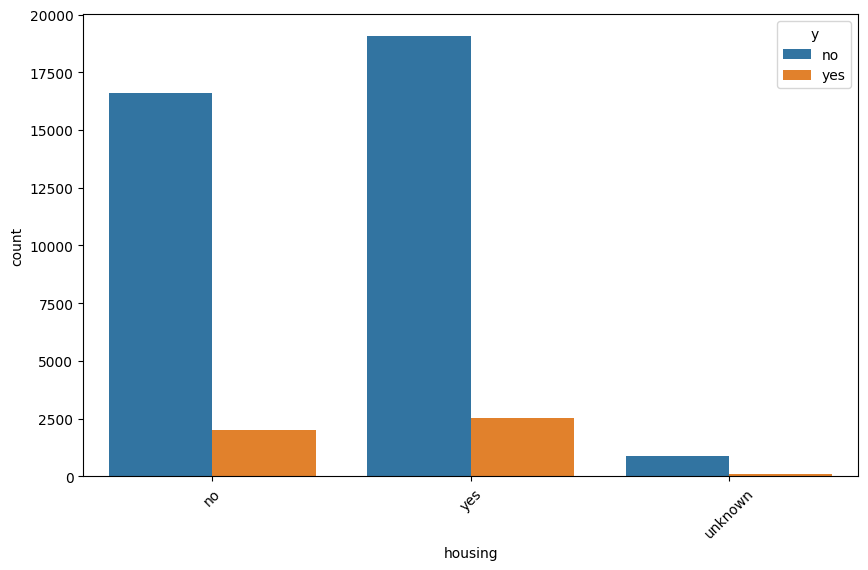

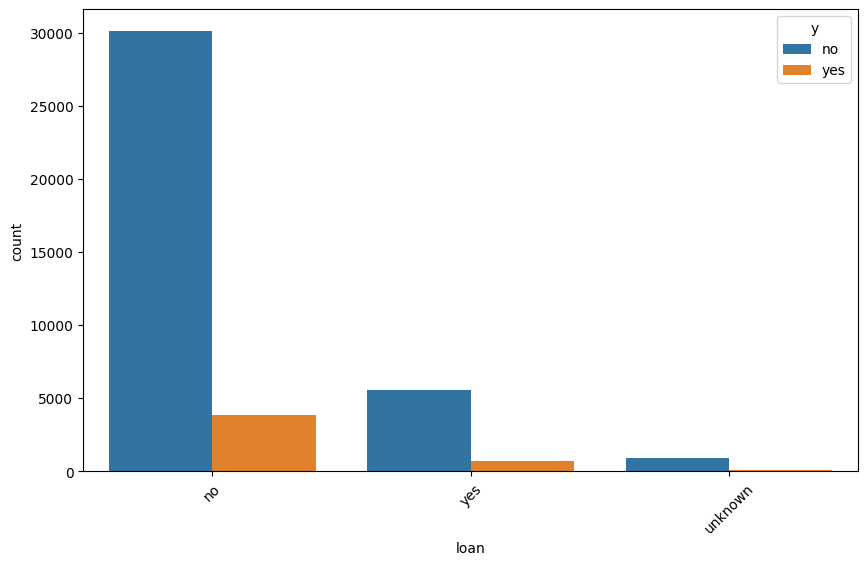

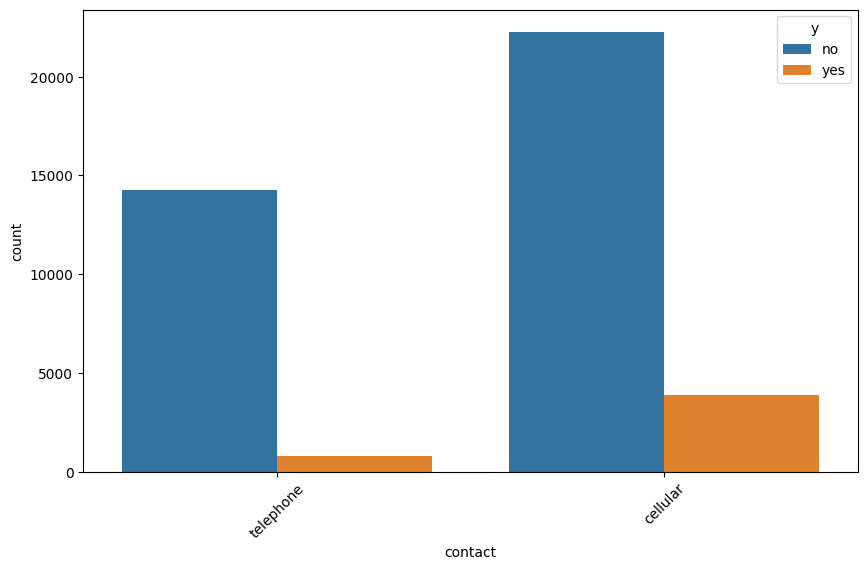

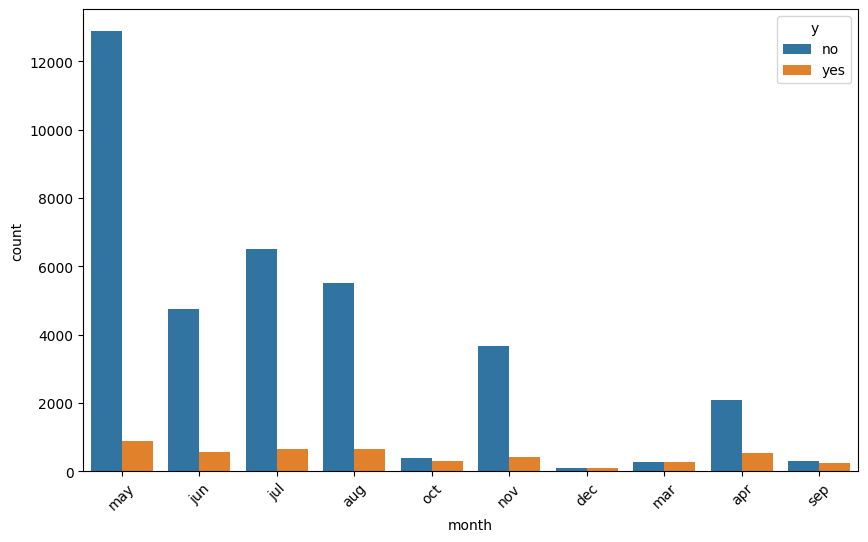

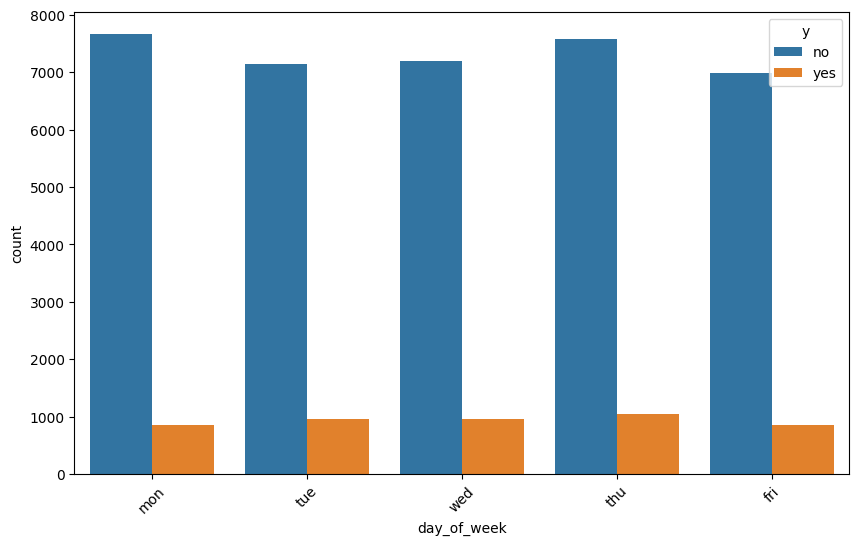

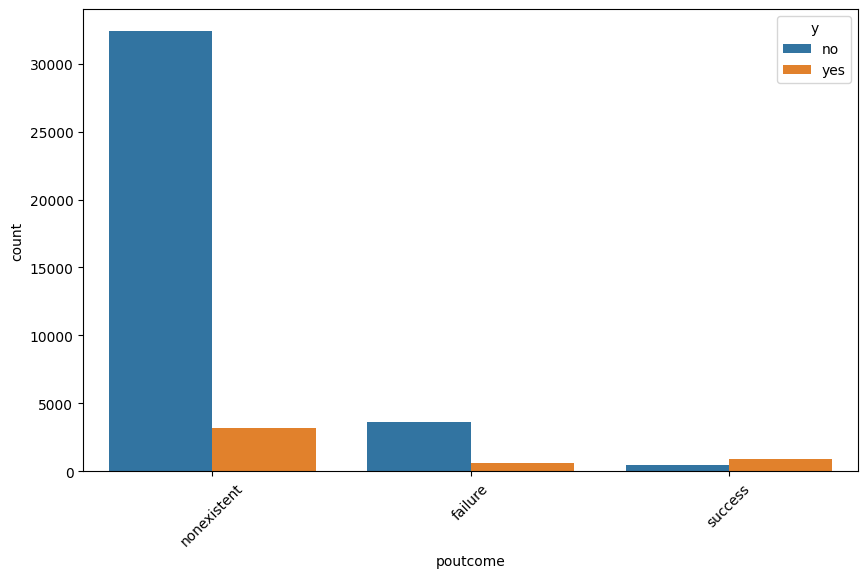

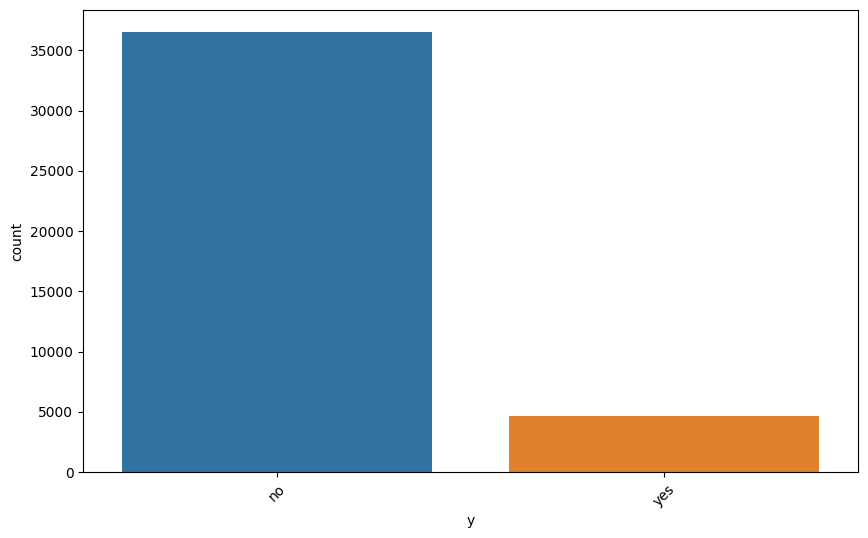

In [10]:
for col in cat_cols:
  plt.figure(figsize=(10, 6))
  sns.countplot(data=df, x=col, hue='y')
  plt.xticks(rotation=45)
  plt.show()

From our graphs we can assume that the dataset is unbalanced. We can see that it contains the response "no" a significant more time than the response "yes". To be exact we have around 89% "no" and 11% "yes".

In [11]:
num_cols = df.select_dtypes(include=['int','float']).columns.tolist()
for var in num_cols:
    print(df[var].value_counts(), '\nlenght:', len(df[var].unique()), '\n\n')

age
31    1947
32    1845
33    1833
36    1779
35    1758
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64 
lenght: 78 


duration
90      170
85      170
136     168
73      167
124     163
       ... 
1569      1
1053      1
1263      1
1169      1
1868      1
Name: count, Length: 1544, dtype: int64 
lenght: 1544 


campaign
1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: count, dtype: int64 
lenght: 42 


pdays
999    39661
3        439
6        412
4        118
9         64

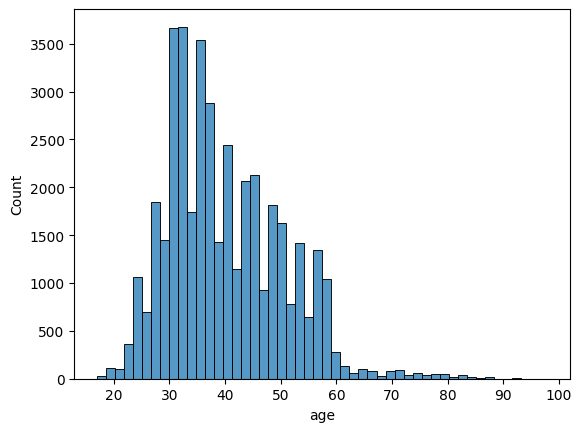

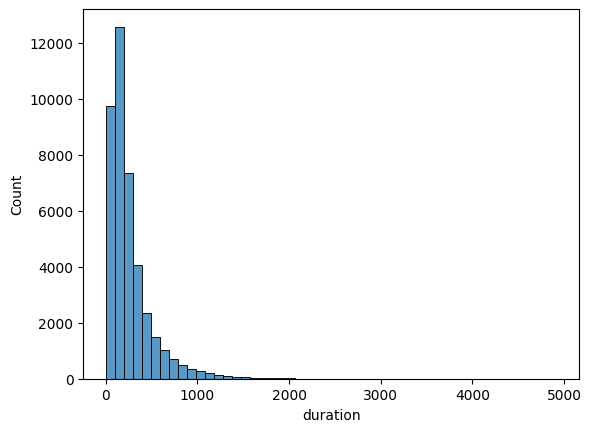

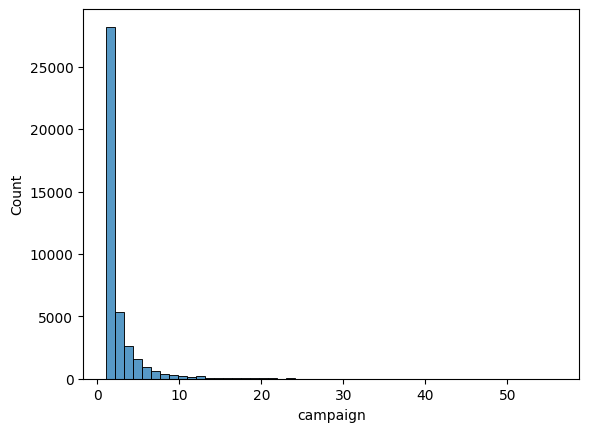

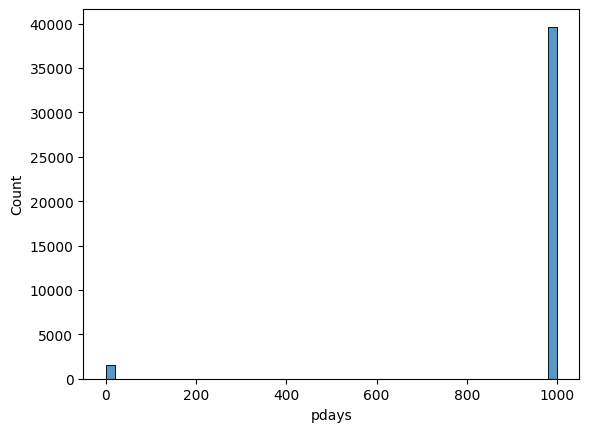

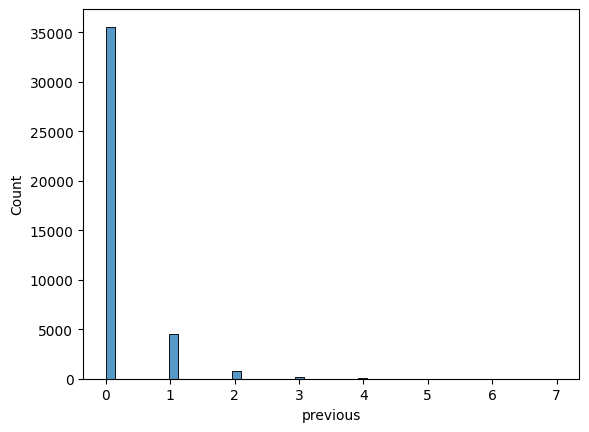

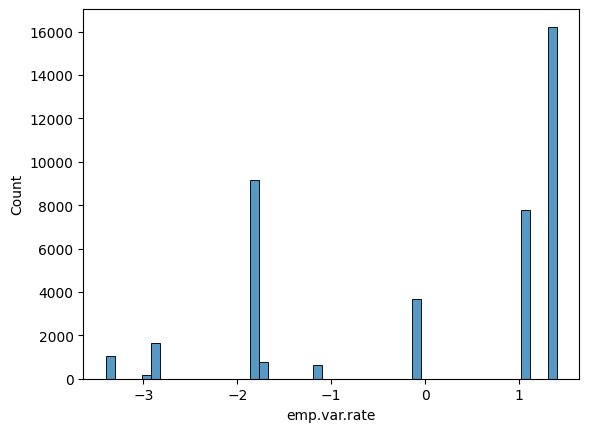

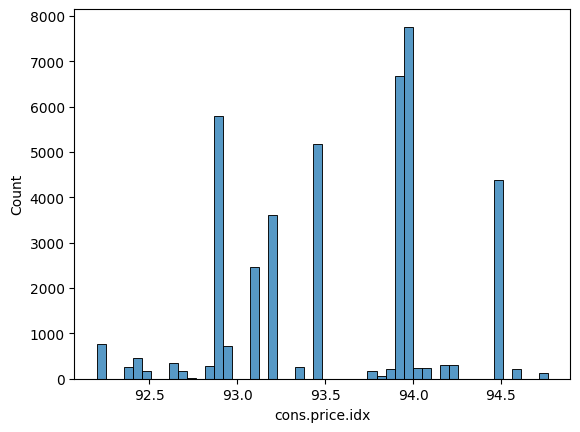

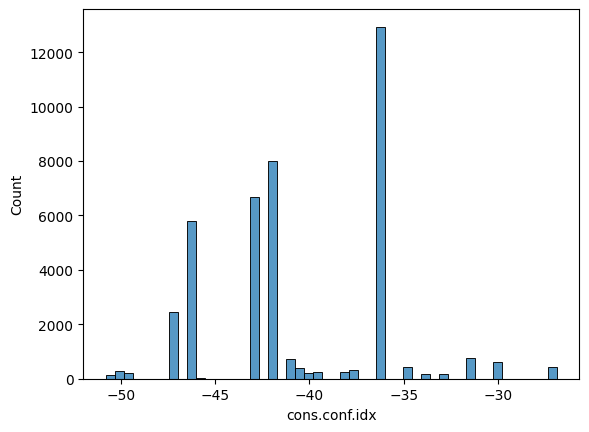

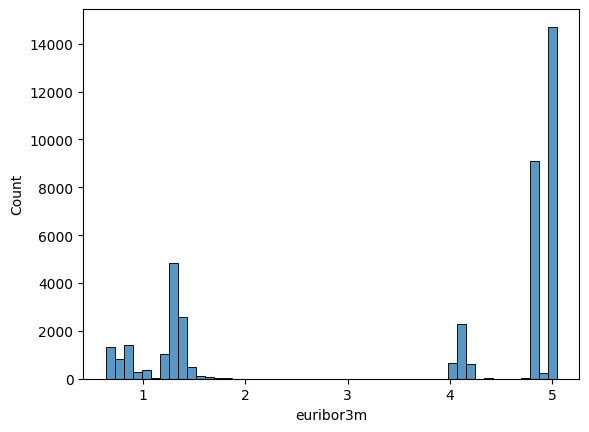

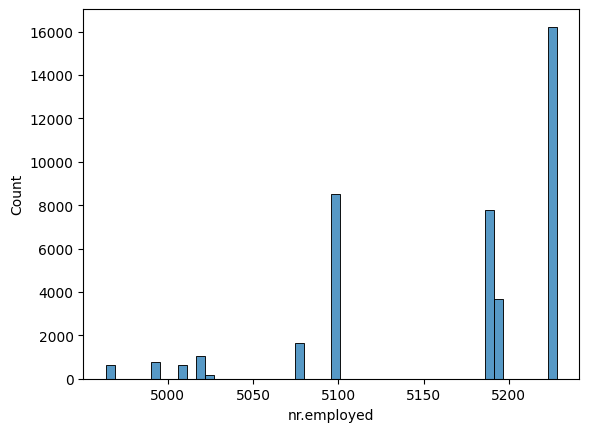

In [12]:
for col in num_cols:
    plt.figure()
    sns.histplot(df[col].dropna(), bins=50)
    plt.show()

<Axes: >

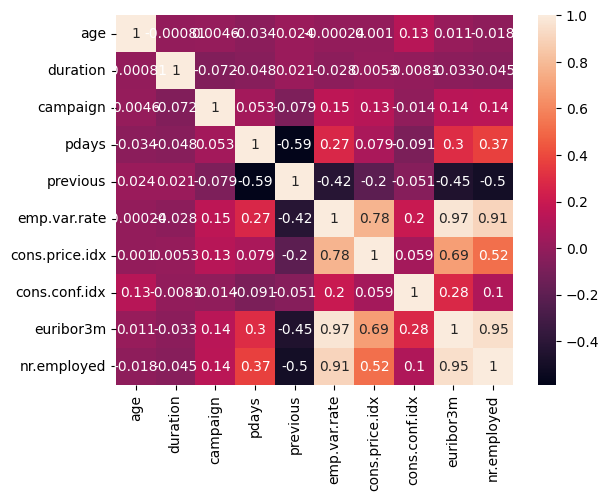

In [13]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [14]:
X = df.drop('y', axis=1)
X_oe = df.drop('y', axis=1)
y = df['y']

In [15]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int','float']).columns.tolist()

In [16]:
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols), ('cat', OrdinalEncoder(), cat_cols)])
ode_enc = OrdinalEncoder()

In [17]:
X_txd = preprocessor.fit_transform(X)

In [18]:
X_txd

array([[ 1.53314313,  0.01035157, -0.56596326, ...,  6.        ,
         1.        ,  1.        ],
       [ 1.62910732, -0.42157694, -0.56596326, ...,  6.        ,
         1.        ,  1.        ],
       [-0.29017656, -0.12462609, -0.56596326, ...,  6.        ,
         1.        ,  1.        ],
       ...,
       [ 1.53314313, -0.26731675, -0.20498953, ...,  7.        ,
         0.        ,  1.        ],
       [ 0.3815728 ,  0.70837889, -0.56596326, ...,  7.        ,
         0.        ,  1.        ],
       [ 3.26049862, -0.07449153,  0.1559842 , ...,  7.        ,
         0.        ,  0.        ]])

In [19]:
X_oe[cat_cols] = ode_enc.fit_transform(X_oe[cat_cols])

In [20]:
X_oe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,3.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,261,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0
1,57,7.0,1.0,3.0,1.0,0.0,0.0,1.0,6.0,1.0,149,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0
2,37,7.0,1.0,3.0,0.0,2.0,0.0,1.0,6.0,1.0,226,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0
3,40,0.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,151,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0
4,56,7.0,1.0,3.0,0.0,0.0,2.0,1.0,6.0,1.0,307,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5.0,1.0,5.0,0.0,2.0,0.0,0.0,7.0,0.0,334,1,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6
41184,46,1.0,1.0,5.0,0.0,0.0,0.0,0.0,7.0,0.0,383,1,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6
41185,56,5.0,1.0,6.0,0.0,2.0,0.0,0.0,7.0,0.0,189,2,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6
41186,44,9.0,1.0,5.0,0.0,0.0,0.0,0.0,7.0,0.0,442,1,999,0,1.0,-1.1,94.767,-50.8,1.028,4963.6


In [21]:
label_encoder = LabelEncoder()
y_txd = label_encoder.fit_transform(y)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_txd, y_txd, test_size=0.2, random_state=42, stratify=y)

Splitting data for KNN, SVM and Logistic Regression

In [23]:
X_train_oe, X_test_oe, y_train, y_test = train_test_split(X_oe, y_txd, test_size=0.2, random_state=42, stratify=y)

Splitting data for Decision Tree

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [24]:
zero_rule_clf = DummyClassifier(strategy="most_frequent")
zero_rule_clf.fit(X_train, y_train)
y_pred = zero_rule_clf.predict(X_test)

print("Zero-Rule Classifier Accuracy:", accuracy_score(y_test, y_pred))

Zero-Rule Classifier Accuracy: 0.8873239436619719


As we have a significantly imbalanced dataset, a Zero-Rule Classifier will form a good baseline for us to compare our model to.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [25]:
lreg = LogisticRegression()
lreg.fit(X_train, y_train)

y_pred = lreg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Problem 9: Score the Model

What is the accuracy of your model?

In [26]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.9101505585235551


With about a 91% accuracy our Logistic Regression model is about 3% more accurate than our baseline.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [27]:
lreg = LogisticRegression()
knn = KNeighborsClassifier()
d_tree = DecisionTreeClassifier()
svm = SVC(probability=True)

scores = {}

In [28]:
start = time.time()
lreg.fit(X_train, y_train)
end = time.time()
train_time = end - start

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
train_accuracy = lreg.score(X_train, y_train)
test_accuracy = lreg.score(X_test, y_test)
y_pred = lreg.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

y_prob = lreg.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

In [30]:
scores['Logistic Regression'] = {'Name': 'Logistic Regression', 'Train Time': train_time, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'precision':precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'y pred': y_pred, 'y_prob': y_prob}

In [31]:
start = time.time()
knn.fit(X_train, y_train)
end = time.time()
train_time = end - start

In [32]:
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)
y_pred = knn.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

y_prob = knn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

In [33]:
scores['KNN'] = {'Name': 'KNN', 'Train Time': train_time, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'precision':precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'y pred': y_pred, 'y_prob': y_prob}

In [34]:
start = time.time()
d_tree.fit(X_train, y_train)
end = time.time()
train_time = end - start

In [35]:
train_accuracy = d_tree.score(X_train, y_train)
test_accuracy = d_tree.score(X_test, y_test)
y_pred = d_tree.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

y_prob = d_tree.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

In [36]:
scores['Decision Tree'] = {'Name': 'Decison Tree', 'Train Time': train_time, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'precision':precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'y pred': y_pred, 'y_prob': y_prob}

In [37]:
start = time.time()
svm.fit(X_train, y_train)
end = time.time()
train_time = end - start

In [38]:
train_accuracy = svm.score(X_train, y_train)
test_accuracy = svm.score(X_test, y_test)
y_pred = svm.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

y_prob = svm.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

In [39]:
scores['SVM'] = {'Name': 'SVM', 'Train Time': train_time, 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'precision':precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'y pred': y_pred, 'y_prob': y_prob}

In [40]:
score_df = pd.DataFrame(scores).transpose().reset_index(drop=True)

In [41]:
classes = ('Logistic Regression', 'KNN', 'Decision Tree', 'SVM')
score = {
    'Train Time': (scores['Logistic Regression']['Train Time'], scores['KNN']['Train Time'], scores['Decision Tree']['Train Time'], scores['SVM']['Train Time']),
    'Train Accuracy': (scores['Logistic Regression']['Train Accuracy'], scores['KNN']['Train Accuracy'], scores['Decision Tree']['Train Accuracy'], scores['SVM']['Train Accuracy']),
    'Test Accuracy': (scores['Logistic Regression']['Test Accuracy'], scores['KNN']['Test Accuracy'], scores['Decision Tree']['Test Accuracy'], scores['SVM']['Test Accuracy']),
    'precision': (scores['Logistic Regression']['precision'], scores['KNN']['precision'], scores['Decision Tree']['precision'], scores['SVM']['precision']),
    'recall': (scores['Logistic Regression']['recall'], scores['KNN']['recall'], scores['Decision Tree']['recall'], scores['SVM']['recall']),
    'f1': (scores['Logistic Regression']['f1'], scores['KNN']['f1'], scores['Decision Tree']['f1'], scores['SVM']['f1']),
    'AUC': (scores['Logistic Regression']['AUC'], scores['KNN']['AUC'], scores['Decision Tree']['AUC'], scores['SVM']['AUC']),
}
score.items()

dict_items([('Train Time', (0.636127233505249, 0.006459474563598633, 0.21050643920898438, 104.34738659858704)), ('Train Accuracy', (0.9102307225258045, 0.9258652094717669, 1.0, 0.909805707346691)), ('Test Accuracy', (0.9101505585235551, 0.9011656143759106, 0.8881738708110734, 0.9074793589120933)), ('precision', (0.6593220338983051, 0.5916398713826366, 0.5035750766087844, 0.6812227074235808)), ('recall', (0.4191810344827586, 0.39655172413793105, 0.53125, 0.33620689655172414)), ('f1', (0.5125164690382082, 0.47483870967741937, 0.5170424750917673, 0.45021645021645024)), ('AUC', (0.9337275635581224, 0.8552309821074685, 0.7323737684729064, 0.9332794540229884))])

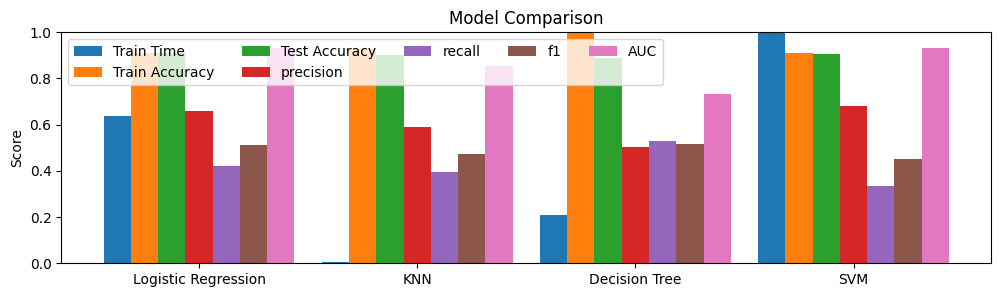

In [42]:
x = np.arange(len(classes))
width = 0.125
multiplier = 0


fig, ax = plt.subplots()

fig.set_size_inches(12, 3)
for types, val in score.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, val, width, label=types)
    multiplier += 1


ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x + 0.375, classes)
ax.legend(loc='upper left', ncols=5)
ax.set_ylim(0, 1)

plt.show()

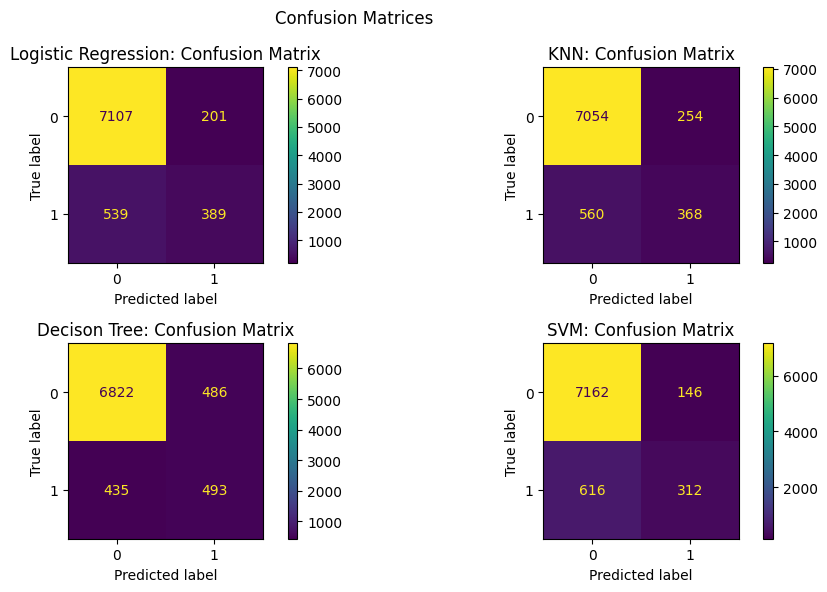

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle('Confusion Matrices')
plot_count = 0

for index, row in score_df.iterrows():
    model = row['Name']
    y_pred = row['y pred']

    ax = axes.flat[plot_count]

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    ax.set_title(f"{model}: Confusion Matrix")
    plot_count += 1

plt.tight_layout()

plt.show()

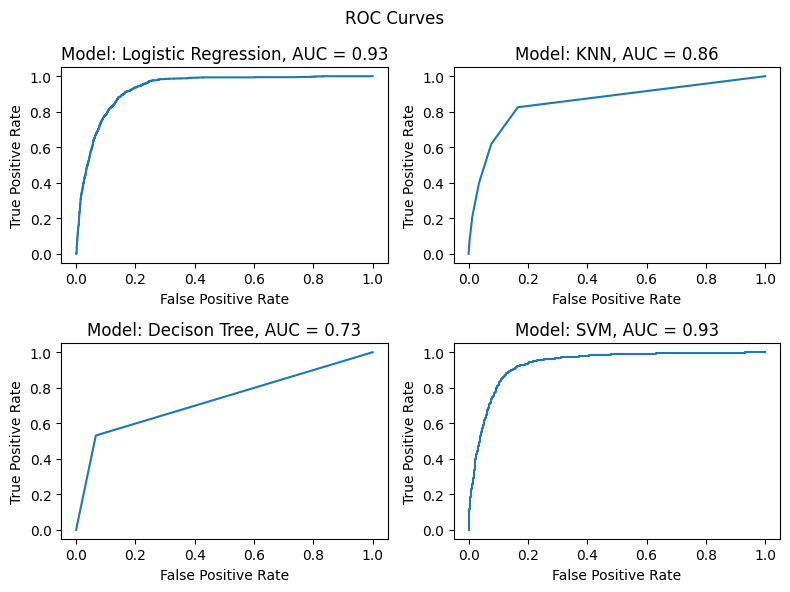

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('ROC Curves')
plot_count = 0

for index, row in score_df.iterrows():
    model = row['Name']
    y_prob = row['y_prob']
    ax = axes.flat[plot_count]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    ax.plot(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"Model: {model}, AUC = {round(row['AUC'],2)}")

    plot_count += 1

plt.tight_layout()

plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [45]:
model_dict = {
    'Logistic Regression': LogisticRegression(),
    'K Nearest Neighbor': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machines': SVC(probability=True)
}

In [46]:
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'saga']
    },

    'Decision Tree': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10]
    },

    'K Nearest Neighbor': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },

    'Support Vector Machines': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }
}

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, label_binarize
from sklearn.model_selection import GridSearchCV

In [48]:
final_scores = {}

for model_name, model in model_dict.items():
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    train_time = end - start
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    final_scores[model_name] = [train_time, train_accuracy, test_accuracy, precision, recall, f1, auc, y_pred]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
final_df = pd.DataFrame(final_scores).T
final_df.columns = ['Train Time', 'Train Accuracy', 'Test Accuracy', 'Precision Score',
                    'Recall Score', 'F1 Score', 'ROC AUC', 'y_pred']
final_df

,Train Time,Train Accuracy,Test Accuracy,Precision Score,Recall Score,F1 Score,ROC AUC,y_pred
Logistic Regression,0.32055,0.910231,0.910151,0.659322,0.419181,0.512516,0.933279,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
K Nearest Neighbor,0.003946,0.925865,0.901166,0.59164,0.396552,0.474839,0.933279,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Decision Tree,0.207525,1.0,0.886353,0.495935,0.525862,0.51046,0.933279,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
Support Vector Machines,105.288455,0.909806,0.907479,0.681223,0.336207,0.450216,0.933279,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


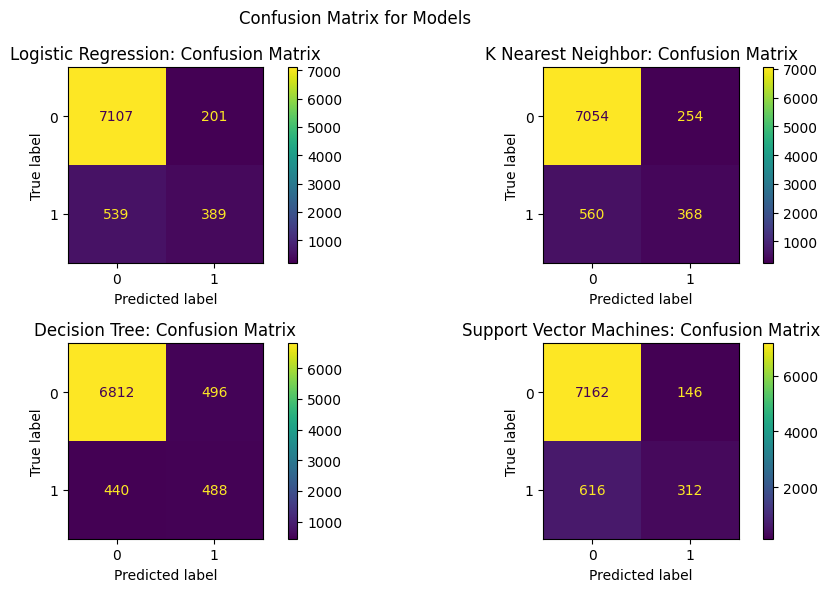

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle('Confusion Matrix for Models')

plot_count = 0

for index, row in final_df.iterrows():
    model = index
    y_pred = row['y_pred']

    ax = axes.flat[plot_count]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    ax.set_title(f"{model}: Confusion Matrix")

    plot_count += 1

plt.tight_layout()

plt.show()

Final Observations:

After tuning hyperparameters, we find that the best model was our Logistic Regression model as it had the highest testing accuracy of around 91%. Our decision tree seems overtuned to the training data as it has 100% training accuracy but only 88% testing accuracy.

##### Questions

A few questions we can ask about the dataset and the campaign are:

1. How many days before the campaign should the bank contact the customers. The duration of the call and the pdays and previous days in the current dataset is not providing enough information to determine the success of the campaign
2. While we see a negative correlation around employment variation rate, it does not translate to any meaningful decisions.
3. There is a good correlation between the duration of the call and contact type. Customers with cellphones show higher reach. The campaign can focus on improving the success by focusing on customers with cellphones